### IMPORT REQUIREMENTS

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import InputLayer, LSTM, Dense, RepeatVector, TimeDistributed, Bidirectional, GRU, SimpleRNN, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, AUC, MeanAbsolutePercentageError, R2Score
from tensorflow.keras.optimizers import Adam

In [2]:
XAU = pd.read_csv('./XAU_USD Historical Data.csv')
BTC = pd.read_csv('./Bitcoin Historical Data.csv')

In [3]:
print("----- GOLD -------------\n", XAU.head())
print("\n----- BITCOIN ----------\n", BTC.head())

----- GOLD -------------
          Date     Price      Open      High       Low  Vol. Change %
0  12/06/2023  2,028.76  2,018.97  2,035.93  2,018.82   NaN    0.46%
1  12/05/2023  2,019.42  2,030.15  2,041.33  2,010.02   NaN   -0.51%
2  12/04/2023  2,029.74  2,071.25  2,135.90  2,020.34   NaN   -1.99%
3  12/01/2023  2,070.90  2,034.49  2,075.34  2,033.75   NaN    1.73%
4  11/30/2023  2,035.75  2,044.80  2,047.59  2,031.84   NaN   -0.43%

----- BITCOIN ----------
          Date     Price      Open      High       Low     Vol. Change %
0  12/06/2023  43,734.6  44,076.2  44,144.5  43,466.7  101.41K   -0.78%
1  12/05/2023  44,076.2  41,989.6  44,424.1  41,424.9   96.84K    4.97%
2  12/04/2023  41,987.8  39,968.6  42,394.4  39,968.6  104.21K    5.05%
3  12/03/2023  39,970.2  39,456.8  40,178.9  39,280.3   35.27K    1.30%
4  12/02/2023  39,458.4  38,688.2  39,673.4  38,646.5   37.09K    1.99%


### DATA PREPROCESSING

* Data Cleaning

In [4]:
def df_CleanTransform(df):

    # change 'Date' to datetime format & sort by 'Date'
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', inplace=True)

    # change data type to float
    df['High'] = df['High'].str.replace(',', '').astype(float)
    df['Low'] = df['Low'].str.replace(',', '').astype(float)
    df['Open'] = df['Open'].str.replace(',', '').astype(float)
    df['Price'] = df['Price'].str.replace(',', '').astype(float)
    
    df['Change %'] = df['Change %'].str.rstrip('%').astype('float') / 100.0

    df.replace(np.nan, '12345.12345', inplace=True)
    df[df['Vol.'] == '12345.12345']
    df['Volume'] = df['Vol.'].str[:-1].astype(float)
    df['m'] = df['Vol.'].str[-1]
    change_value = {'K': 1000, 'M': 1000000, 'B': 1000000000, '5': 1}
    df['m'] = df['m'].map(change_value)
    df['Vol.'] = df['Volume']*df['m']
    df.replace(12345.1234, np.nan, inplace=True)
    df.drop(['Volume', 'm'], axis=1, inplace=True)

    return df

XAU = df_CleanTransform(XAU)
BTC = df_CleanTransform(BTC)

In [5]:
print("----- nulls in the GOLD dataset -------------\n", XAU.isna().sum())
print("\n----- nulls in the BITCOIN dataset ----------\n", BTC.isna().sum())

----- nulls in the GOLD dataset -------------
 Date           0
Price          0
Open           0
High           0
Low            0
Vol.        3889
Change %       0
dtype: int64

----- nulls in the BITCOIN dataset ----------
 Date        0
Price       0
Open        0
High        0
Low         0
Vol.        6
Change %    0
dtype: int64


In [6]:
XAU.drop('Vol.', axis=1, inplace=True)
BTC.dropna(subset=['Vol.'], inplace=True)

* Technical Feature Extraction

In [7]:
def technical_indicators(df):

    # Rate Of Change
    df['ROC_26'] = ta.momentum.ROCIndicator(close=df['Price'], window=26).roc()
    df['ROC_34'] = ta.momentum.ROCIndicator(close=df['Price'], window=34).roc()
    df['ROC_52'] = ta.momentum.ROCIndicator(close=df['Price'], window=52).roc()
    df['ROC_68'] = ta.momentum.ROCIndicator(close=df['Price'], window=68).roc()    
    df['ROC_78'] = ta.momentum.ROCIndicator(close=df['Price'], window=78).roc()
    df['ROC_102'] = ta.momentum.ROCIndicator(close=df['Price'], window=102).roc()

    # Exponential Moving Average
    df['EMA_14'] = ta.trend.EMAIndicator(close=df['Price'], window=14).ema_indicator() # short-term
    df['EMA_50'] = ta.trend.EMAIndicator(close=df['Price'], window=50).ema_indicator() # mid-term
    df['EMA_120'] = ta.trend.EMAIndicator(close=df['Price'], window=120).ema_indicator() # long-term

    # Relative Strength Index
    df['RSI_28'] = ta.momentum.RSIIndicator(close=df['Price'], window=28).rsi() #mid-term
    df['RSI_28_SMA14'] = ta.trend.SMAIndicator(close=df['RSI_28'], window=14).sma_indicator() # simple moving average of RSI

    # Moving Average Convergence Divergence - LongTerm
    df['MACD_long_macd'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd()
    df['MACD_long_diff'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd_diff()
    df['MACD_long_signal'] = ta.trend.MACD(close=df['Price'], window_slow=120, window_fast=52, window_sign=20).macd_signal()

    # Moving Average Convergence Divergence - MidTerm
    df['MACD_mid_macd'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd()
    df['MACD_mid_diff'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd_diff()
    df['MACD_mid_signal'] = ta.trend.MACD(close=df['Price'], window_slow=52, window_fast=26, window_sign=10).macd_signal()

    # Bollinger Bands - LongTerm
    df['BB_50_high'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_hband()
    df['BB_50_low'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_lband()
    df['BB_50_width'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_wband()
    df['BB_50_percentage'] = ta.volatility.BollingerBands(close=df['Price'], window=50, window_dev=2).bollinger_pband()

    # Bollinger Bands - MidTerm
    df['BB_20_high'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_hband()
    df['BB_20_low'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_lband()
    df['BB_20_width'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_wband()
    df['BB_20_percentage'] = ta.volatility.BollingerBands(close=df['Price'], window=20, window_dev=1.5).bollinger_pband()

    # Ichimoku Cloud
    df['IchiCloud_SpanA'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_a()
    df['IchiCloud_SpanB'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_b()
    df['IchiCloud_KijunSen'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_base_line()
    df['IchiCloud_TenkanSen'] = ta.trend.IchimokuIndicator(high=df['High'], low=df['Low'], visual=True).ichimoku_conversion_line()

    return df

XAU = technical_indicators(XAU)
BTC = technical_indicators(BTC)

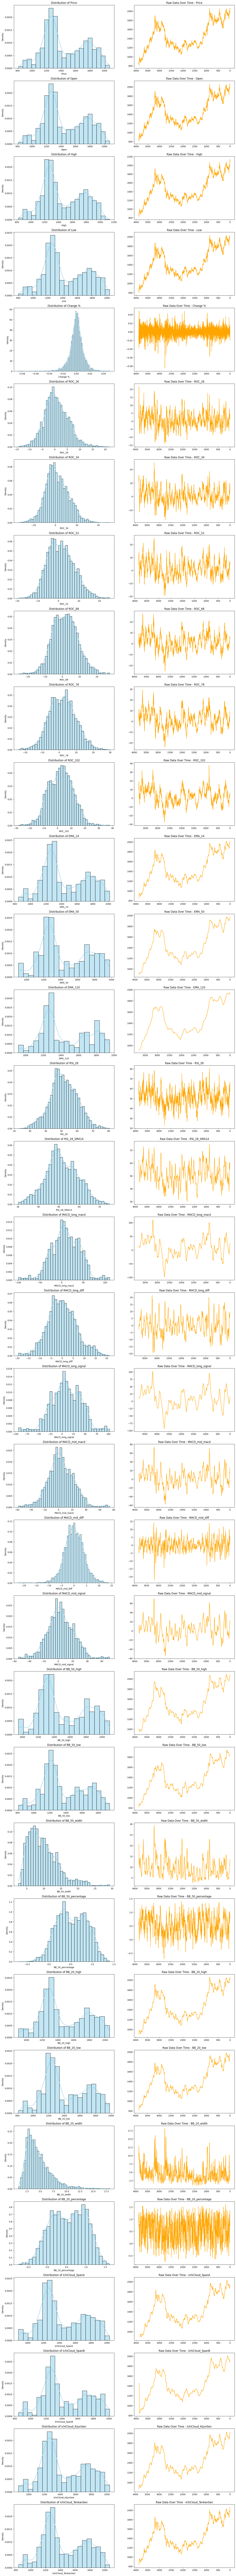

In [8]:
fig, axes = plt.subplots(nrows=len(XAU.columns[1:]), ncols=2, figsize=(18, 6 * len(XAU.columns)))

for i, column in enumerate(XAU.columns[1:]):
    # Distribution plot
    sns.histplot(XAU[column], kde=True, ax=axes[i, 0], color='skyblue', stat='density')
    axes[i, 0].set_title(f'Distribution of {column}')

    # Raw data over time
    XAU[column].plot(ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Raw Data Over Time - {column}')
    axes[i, 1].invert_xaxis() 

In [8]:
xau_test = XAU.copy()
xau_test.dropna(inplace=True)
xau_test.drop(['Date', 'High', 'Low', 'Open'], axis=1, inplace=True)

In [58]:
def maxmin_normalization(df, test_split, log_scaling=False):

    try:
        train_set = df.iloc[:int(test_split * len(df)),:]
        test_set = df.iloc[int(test_split * len(df)):,:]
    except:
        train_set = df.iloc[:int(test_split * len(df))]
        test_set = df.iloc[int(test_split * len(df)):]        

    MaxMin = {}

    for column_ in df.columns:

        if log_scaling:
            train_set[f'{column_}'] = np.log(train_set[f'{column_}'])
            test_set[f'{column_}'] = np.log(test_set[f'{column_}'])

        min_, max_ = min(train_set[f'{column_}']), max(train_set[f'{column_}'])
        MaxMin[f'{column_}'] = [min_, max_]

        train_set[f'{column_}'] = (train_set[f'{column_}'] - min_) / (max_ - min_)
        test_set[f'{column_}'] = (test_set[f'{column_}'] - min_) / (max_ - min_)

    df = pd.concat([train_set, test_set])
        
    return df, MaxMin

In [10]:
def to_supervised(df, target, n_input, n_output=1):

    target_series = df[f'{target}'].to_numpy()
    series = df.to_numpy()

    X = []
    Y = []

    i = 0
    while i < (len(df) - n_input - n_output + 1):
        
        inputs = [row for row in series[i:i+n_input]]
        X.append(inputs)

        outputs = target_series[i+n_input:i+n_input+n_output]
        Y.append(outputs)

        i += 1  

    return np.array(X), np.array(Y)

In [11]:
normal_xau, maxmin_dict = maxmin_normalization(xau_test, 0.8)
X, Y = to_supervised(normal_xau, 'Price', 100, 20)

X_Train, X_Valid, X_Test = X[:int(0.8 * 0.8 * len(X)),:], X[int(0.8 * 0.8 * len(X)):int(0.8 * len(X)),:], X[int(0.8 * len(X)):,:]
Y_Train, Y_Valid, Y_Test = Y[:int(0.8 * 0.8 * len(Y)),:], Y[int(0.8 * 0.8 * len(Y)):int(0.8 * len(Y)),:], Y[int(0.8 * len(Y)):,:]

n_steps , n_features, n_output = X_Train.shape[1], X_Train.shape[2], Y_Train.shape[1]

C:\Users\a.zohdi\AppData\Local\Temp\ipykernel_22376\3844939208.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[f'{column_}'] = (train_set[f'{column_}'] - min_) / (max_ - min_)
C:\Users\a.zohdi\AppData\Local\Temp\ipykernel_22376\3844939208.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[f'{column_}'] = (test_set[f'{column_}'] - min_) / (max_ - min_)


Epoch 1/100
117/117 [==============================] - 3s 19ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - mean_absolute_percentage_error: 16.5208 - r2_score: 0.6423 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633 - val_mean_absolute_percentage_error: 8.3153 - val_r2_score: 0.9050
Epoch 2/100
117/117 [==============================] - 2s 18ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 10.4326 - r2_score: 0.9273 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467 - val_mean_absolute_percentage_error: 6.1601 - val_r2_score: 0.9483
Epoch 3/100
117/117 [==============================] - 2s 18ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - mean_absolute_percentage_error: 9.4893 - r2_score: 0.9397 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470 - val_mean_absolute_percentage_error: 6.1490 - val_r2_score: 0.9477
Epoch 4/100
117/117 [==============================] - 2s 18ms/step - loss: 0.0014 - root_me

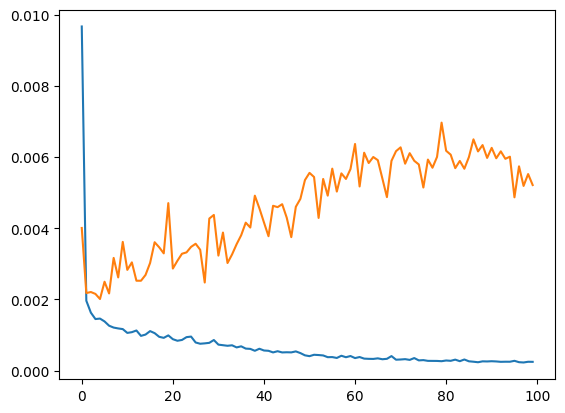

In [41]:
model_vanillaLSTM = Sequential()
model_vanillaLSTM.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features)))
model_vanillaLSTM.add(Dense(n_output))

model_vanillaLSTM.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_vanillaLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_vanillaLSTM.history.history['loss'], model_vanillaLSTM.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 4s 25ms/step - loss: 0.0188 - root_mean_squared_error: 0.1371 - mean_absolute_percentage_error: 22.7057 - r2_score: 0.3045 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623 - val_mean_absolute_percentage_error: 8.2715 - val_r2_score: 0.9081
Epoch 2/100
117/117 [==============================] - 3s 23ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - mean_absolute_percentage_error: 10.7773 - r2_score: 0.9242 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544 - val_mean_absolute_percentage_error: 6.8804 - val_r2_score: 0.9299
Epoch 3/100
117/117 [==============================] - 3s 24ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - mean_absolute_percentage_error: 10.0806 - r2_score: 0.9349 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0519 - val_mean_absolute_percentage_error: 6.6044 - val_r2_score: 0.9363
Epoch 4/100
117/117 [==============================] - 3s 24ms/step - loss: 0.0016 - root_m

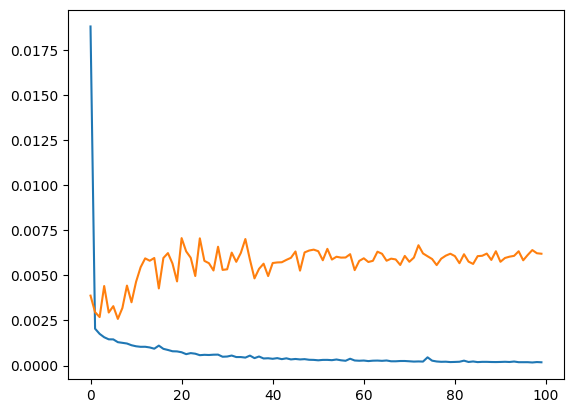

In [42]:
model_stackedLSTM = Sequential()
model_stackedLSTM.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_stackedLSTM.add(LSTM(64, activation='relu'))
model_stackedLSTM.add(Dense(n_output))

model_stackedLSTM.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_stackedLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_stackedLSTM.history.history['loss'], model_stackedLSTM.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 53s 15ms/step - loss: 0.0181 - root_mean_squared_error: 0.1345 - mean_absolute_percentage_error: 23.2694 - r2_score: 0.3306 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690 - val_mean_absolute_percentage_error: 8.9605 - val_r2_score: 0.8875
Epoch 2/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - mean_absolute_percentage_error: 11.3361 - r2_score: 0.9177 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0616 - val_mean_absolute_percentage_error: 7.3978 - val_r2_score: 0.9104
Epoch 3/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - mean_absolute_percentage_error: 10.1210 - r2_score: 0.9342 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 6.5982 - val_r2_score: 0.9383
Epoch 4/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0017 - root_

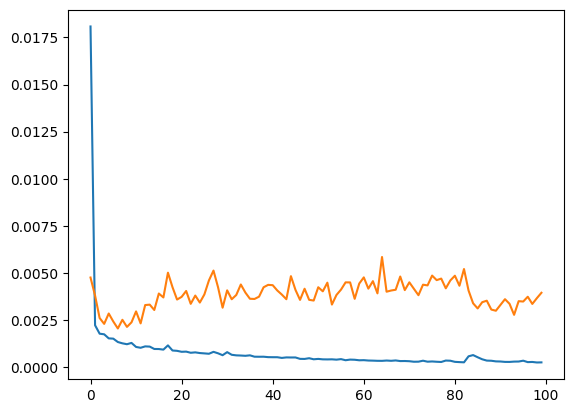

In [43]:
model_biLSTM = Sequential()
model_biLSTM.add(Bidirectional(LSTM(64, activation='relu'), input_shape=(n_steps, n_features)))
model_biLSTM.add(Dense(n_output))

model_biLSTM.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_biLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_biLSTM.history.history['loss'], model_biLSTM.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 3s 19ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - mean_absolute_percentage_error: 20.4820 - r2_score: 0.5280 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574 - val_mean_absolute_percentage_error: 7.2618 - val_r2_score: 0.9219
Epoch 2/100
117/117 [==============================] - 2s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - mean_absolute_percentage_error: 9.9105 - r2_score: 0.9335 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0443 - val_mean_absolute_percentage_error: 5.9535 - val_r2_score: 0.9534
Epoch 3/100
117/117 [==============================] - 2s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - mean_absolute_percentage_error: 9.2424 - r2_score: 0.9419 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497 - val_mean_absolute_percentage_error: 6.4112 - val_r2_score: 0.9415
Epoch 4/100
117/117 [==============================] - 2s 17ms/step - loss: 0.0015 - root_mea

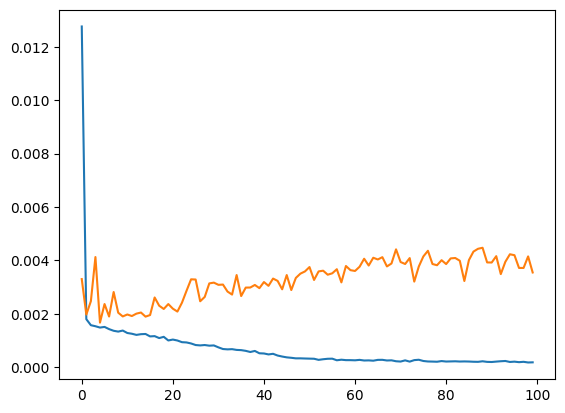

In [44]:
model_vanillaGRU = Sequential()
model_vanillaGRU.add(GRU(128, activation='tanh', input_shape=(n_steps, n_features)))
model_vanillaGRU.add(Dense(n_output))

model_vanillaGRU.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_vanillaGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_vanillaGRU.history.history['loss'], model_vanillaGRU.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 5s 28ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141 - mean_absolute_percentage_error: 20.9886 - r2_score: 0.5177 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0808 - val_mean_absolute_percentage_error: 10.1050 - val_r2_score: 0.8453
Epoch 2/100
117/117 [==============================] - 3s 24ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - mean_absolute_percentage_error: 10.0857 - r2_score: 0.9301 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562 - val_mean_absolute_percentage_error: 6.7226 - val_r2_score: 0.9251
Epoch 3/100
117/117 [==============================] - 3s 24ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - mean_absolute_percentage_error: 9.5740 - r2_score: 0.9378 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 6.9958 - val_r2_score: 0.9223
Epoch 4/100
117/117 [==============================] - 3s 24ms/step - loss: 0.0016 - root_m

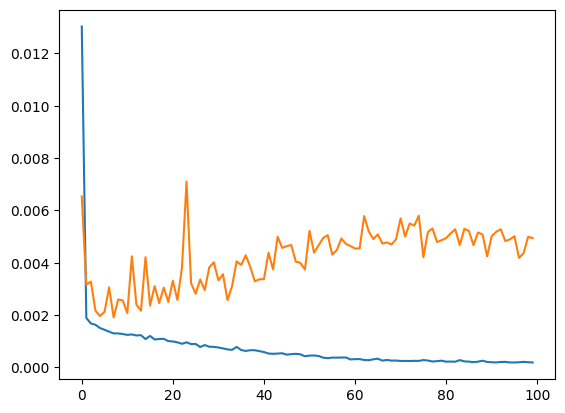

In [45]:
model_stackedGRU = Sequential()
model_stackedGRU.add(GRU(64, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
model_stackedGRU.add(GRU(64, activation='tanh'))
model_stackedGRU.add(Dense(n_output))

model_stackedGRU.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_stackedGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_stackedGRU.history.history['loss'], model_stackedGRU.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 4s 17ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - mean_absolute_percentage_error: 23.9164 - r2_score: 0.5142 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0656 - val_mean_absolute_percentage_error: 8.4567 - val_r2_score: 0.8980
Epoch 2/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - mean_absolute_percentage_error: 11.4369 - r2_score: 0.9140 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0634 - val_mean_absolute_percentage_error: 7.8786 - val_r2_score: 0.9049
Epoch 3/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0430 - mean_absolute_percentage_error: 10.1918 - r2_score: 0.9315 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494 - val_mean_absolute_percentage_error: 6.2839 - val_r2_score: 0.9421
Epoch 4/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0016 - root_m

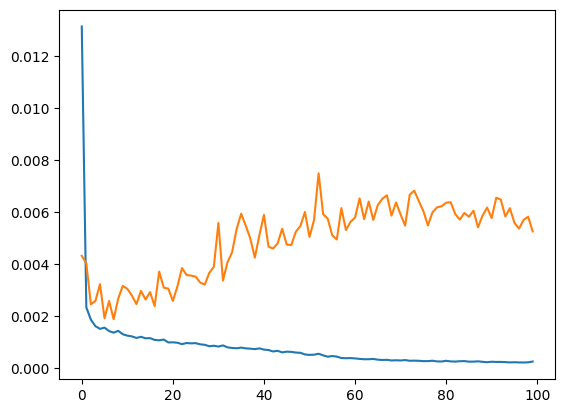

In [46]:
model_biGRU = Sequential()
model_biGRU.add(Bidirectional(GRU(64, activation='tanh'), input_shape=(n_steps, n_features)))
model_biGRU.add(Dense(n_output))

model_biGRU.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_biGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_biGRU.history.history['loss'], model_biGRU.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 1s 8ms/step - loss: 0.0211 - root_mean_squared_error: 0.1452 - mean_absolute_percentage_error: 24.4902 - r2_score: 0.2184 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0764 - val_mean_absolute_percentage_error: 10.2454 - val_r2_score: 0.8616
Epoch 2/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - mean_absolute_percentage_error: 11.4201 - r2_score: 0.9131 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640 - val_mean_absolute_percentage_error: 8.5117 - val_r2_score: 0.9028
Epoch 3/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - mean_absolute_percentage_error: 10.1696 - r2_score: 0.9302 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581 - val_mean_absolute_percentage_error: 7.2490 - val_r2_score: 0.9200
Epoch 4/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0018 - root_mean

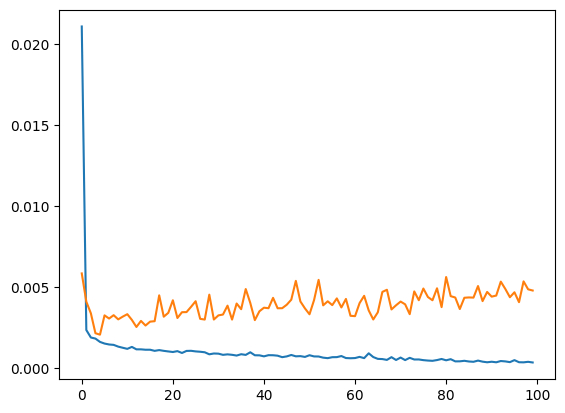

In [47]:
model_vanillaRNN = Sequential()
model_vanillaRNN.add(SimpleRNN(128, activation='relu', input_shape=(n_steps, n_features)))
model_vanillaRNN.add(Dense(n_output))

model_vanillaRNN.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_vanillaRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_vanillaRNN.history.history['loss'], model_vanillaRNN.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 3s 15ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - mean_absolute_percentage_error: 24.3463 - r2_score: 0.2748 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641 - val_mean_absolute_percentage_error: 8.2103 - val_r2_score: 0.9025
Epoch 2/100
117/117 [==============================] - 1s 13ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - mean_absolute_percentage_error: 11.5333 - r2_score: 0.9125 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489 - val_mean_absolute_percentage_error: 6.9121 - val_r2_score: 0.9433
Epoch 3/100
117/117 [==============================] - 2s 13ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - mean_absolute_percentage_error: 10.5147 - r2_score: 0.9260 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471 - val_mean_absolute_percentage_error: 6.2776 - val_r2_score: 0.9474
Epoch 4/100
117/117 [==============================] - 1s 13ms/step - loss: 0.0019 - root_m

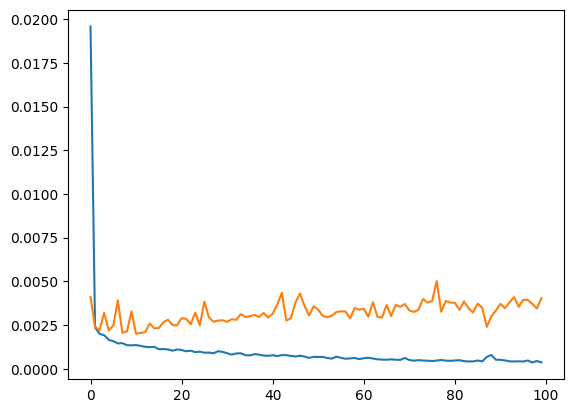

In [48]:
model_stackedRNN = Sequential()
model_stackedRNN.add(SimpleRNN(64, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model_stackedRNN.add(SimpleRNN(64, activation='relu'))
model_stackedRNN.add(Dense(n_output))

model_stackedRNN.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_stackedRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_stackedRNN.history.history['loss'], model_stackedRNN.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 5s 24ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - mean_absolute_percentage_error: 28.1535 - r2_score: 0.1641 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856 - val_mean_absolute_percentage_error: 11.2499 - val_r2_score: 0.8268
Epoch 2/100
117/117 [==============================] - 2s 20ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - mean_absolute_percentage_error: 13.6870 - r2_score: 0.8755 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_percentage_error: 7.9274 - val_r2_score: 0.9264
Epoch 3/100
117/117 [==============================] - 2s 21ms/step - loss: 0.0026 - root_mean_squared_error: 0.0510 - mean_absolute_percentage_error: 11.9960 - r2_score: 0.9038 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528 - val_mean_absolute_percentage_error: 7.0192 - val_r2_score: 0.9338
Epoch 4/100
117/117 [==============================] - 2s 20ms/step - loss: 0.0022 - root_

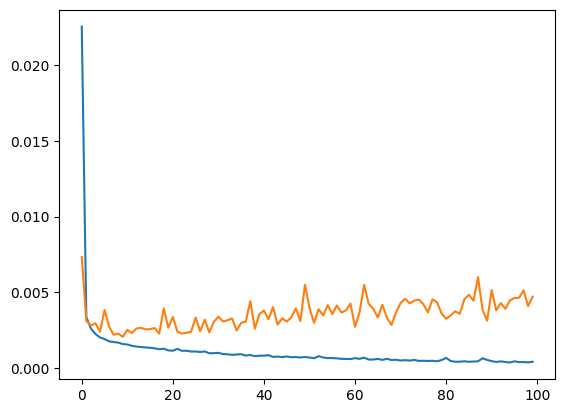

In [49]:
model_biRNN = Sequential()
model_biRNN.add(Bidirectional(SimpleRNN(64, activation='relu'), input_shape=(n_steps, n_features)))
model_biRNN.add(Dense(n_output))

model_biRNN.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_biRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_biRNN.history.history['loss'], model_biRNN.history.history['val_loss'])

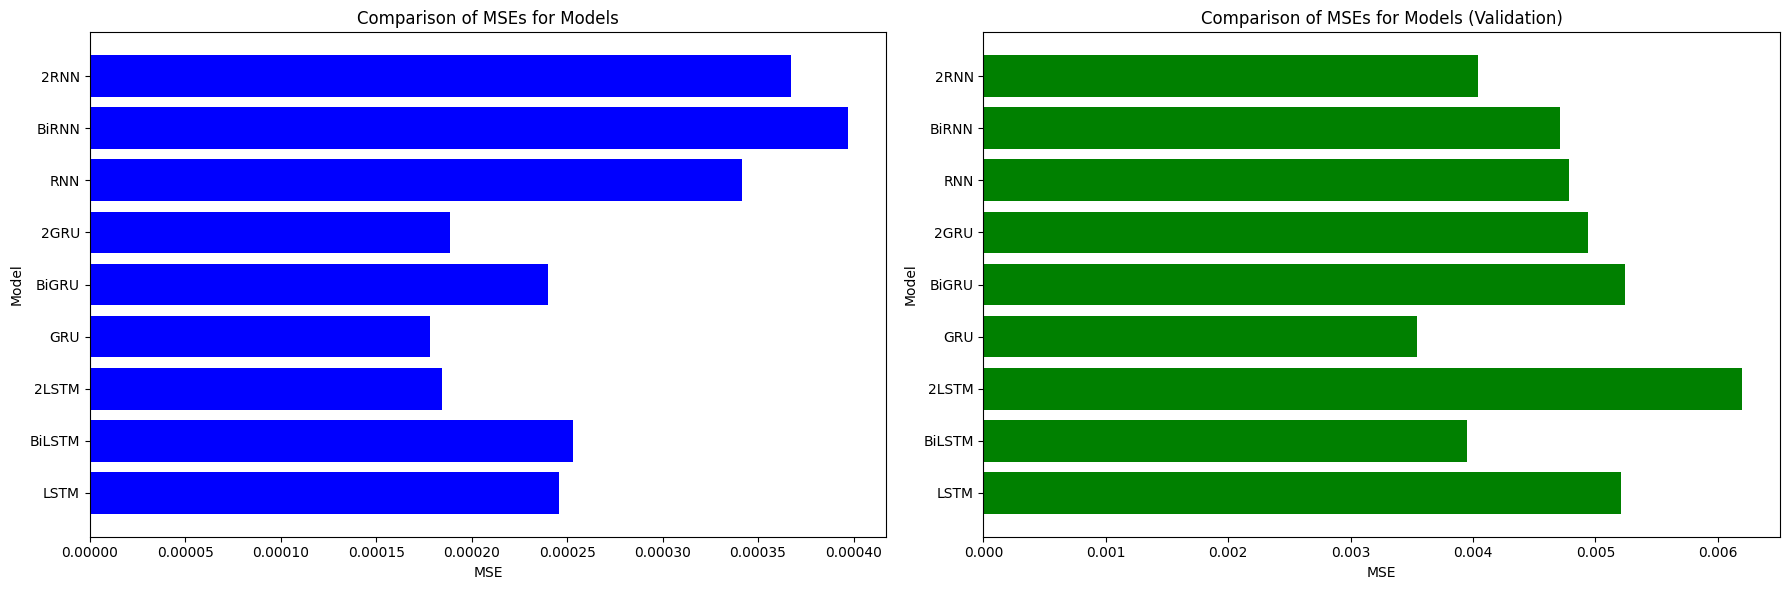

In [50]:
model_names = ['LSTM', 'BiLSTM', '2LSTM', 'GRU', 'BiGRU', '2GRU', 'RNN', 'BiRNN', '2RNN']

model_mse = [model_vanillaLSTM.history.history['loss'][-1], model_biLSTM.history.history['loss'][-1], model_stackedLSTM.history.history['loss'][-1],
             model_vanillaGRU.history.history['loss'][-1], model_biGRU.history.history['loss'][-1], model_stackedGRU.history.history['loss'][-1],
             model_vanillaRNN.history.history['loss'][-1], model_biRNN.history.history['loss'][-1], model_stackedRNN.history.history['loss'][-1]]

model_mse_validation = [model_vanillaLSTM.history.history['val_loss'][-1], model_biLSTM.history.history['val_loss'][-1], model_stackedLSTM.history.history['val_loss'][-1],
                        model_vanillaGRU.history.history['val_loss'][-1], model_biGRU.history.history['val_loss'][-1], model_stackedGRU.history.history['val_loss'][-1],
                        model_vanillaRNN.history.history['val_loss'][-1], model_biRNN.history.history['val_loss'][-1], model_stackedRNN.history.history['val_loss'][-1]]


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].barh(model_names, model_mse, color='blue')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')
axes[0].set_title('Comparison of MSEs for Models')

axes[1].barh(model_names, model_mse_validation, color='green')
axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Model')
axes[1].set_title('Comparison of MSEs for Models (Validation)')

plt.tight_layout()
plt.show()

In [51]:
df_withValidation = pd.DataFrame({'model':model_names, 'MSE':model_mse, 'MSE Validation': model_mse_validation})
df_withValidation

model       MSE  MSE Validation
0    LSTM  0.000246        0.005212
1  BiLSTM  0.000253        0.003948
2   2LSTM  0.000184        0.006199
3     GRU  0.000178        0.003544
4   BiGRU  0.000240        0.005245
5    2GRU  0.000189        0.004939
6     RNN  0.000342        0.004786
7   BiRNN  0.000397        0.004708
8    2RNN  0.000367        0.004038

Epoch 1/100
117/117 [==============================] - 2s 12ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - mean_absolute_percentage_error: 18.2936 - r2_score: 0.6045 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 7.2137 - val_r2_score: 0.9220
Epoch 2/100
117/117 [==============================] - 1s 11ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - mean_absolute_percentage_error: 11.0931 - r2_score: 0.9120 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492 - val_mean_absolute_percentage_error: 6.2762 - val_r2_score: 0.9426
Epoch 3/100
117/117 [==============================] - 1s 11ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - mean_absolute_percentage_error: 10.1151 - r2_score: 0.9282 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460 - val_mean_absolute_percentage_error: 5.8433 - val_r2_score: 0.9499
Epoch 4/100
117/117 [==============================] - 1s 11ms/step - loss: 0.0016 - root_m

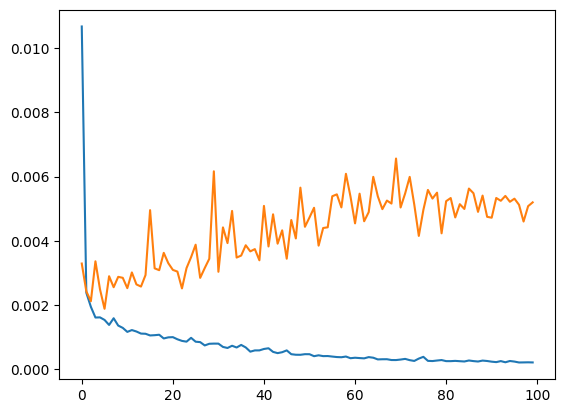

In [19]:
model_CNNvanillaLSTM = Sequential()
model_CNNvanillaLSTM.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNvanillaLSTM.add(MaxPooling1D(pool_size=2))
model_CNNvanillaLSTM.add(LSTM(128, activation='relu', input_shape=(n_steps, n_features)))
model_CNNvanillaLSTM.add(Dense(n_output))

model_CNNvanillaLSTM.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNvanillaLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNvanillaLSTM.history.history['loss'], model_CNNvanillaLSTM.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 3s 16ms/step - loss: 0.0111 - root_mean_squared_error: 0.1055 - mean_absolute_percentage_error: 18.8327 - r2_score: 0.5876 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0921 - val_mean_absolute_percentage_error: 10.0251 - val_r2_score: 0.7999
Epoch 2/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - mean_absolute_percentage_error: 11.2712 - r2_score: 0.9139 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573 - val_mean_absolute_percentage_error: 7.3272 - val_r2_score: 0.9223
Epoch 3/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - mean_absolute_percentage_error: 10.6231 - r2_score: 0.9243 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541 - val_mean_absolute_percentage_error: 7.0178 - val_r2_score: 0.9309
Epoch 4/100
117/117 [==============================] - 2s 14ms/step - loss: 0.0019 - root_

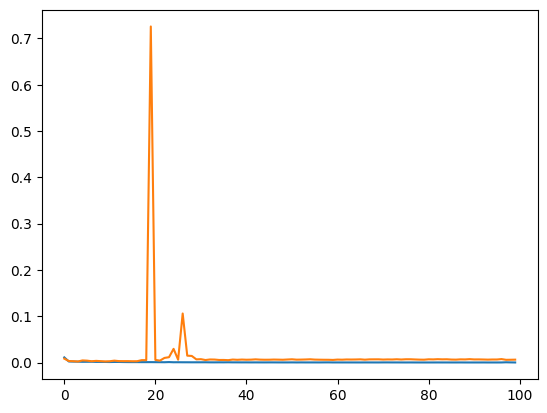

In [20]:
model_CNNstackedLSTM = Sequential()
model_CNNstackedLSTM.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNstackedLSTM.add(MaxPooling1D(pool_size=2))
model_CNNstackedLSTM.add(LSTM(64, activation='relu', return_sequences=True))
model_CNNstackedLSTM.add(LSTM(64, activation='relu'))
model_CNNstackedLSTM.add(Dense(n_output))

model_CNNstackedLSTM.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNstackedLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNstackedLSTM.history.history['loss'], model_CNNstackedLSTM.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 3s 12ms/step - loss: 0.0138 - root_mean_squared_error: 0.1177 - mean_absolute_percentage_error: 21.0492 - r2_score: 0.4876 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550 - val_mean_absolute_percentage_error: 7.2275 - val_r2_score: 0.9283
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - mean_absolute_percentage_error: 10.3814 - r2_score: 0.9285 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0482 - val_mean_absolute_percentage_error: 6.3152 - val_r2_score: 0.9449
Epoch 3/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0016 - root_mean_squared_error: 0.0396 - mean_absolute_percentage_error: 9.5327 - r2_score: 0.9420 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509 - val_mean_absolute_percentage_error: 6.6587 - val_r2_score: 0.9386
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0016 - root_mean_

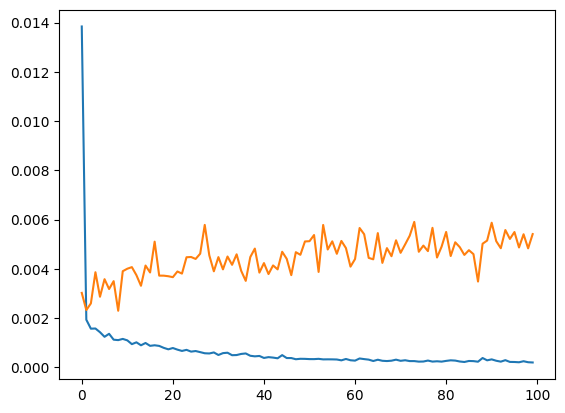

In [21]:
model_CNNbiLSTM = Sequential()
model_CNNbiLSTM.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNbiLSTM.add(MaxPooling1D(pool_size=2))
model_CNNbiLSTM.add(Bidirectional(LSTM(64, activation='relu')))
model_CNNbiLSTM.add(Dense(n_output))

model_CNNbiLSTM.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNbiLSTM.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNbiLSTM.history.history['loss'], model_CNNbiLSTM.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 3s 13ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964 - mean_absolute_percentage_error: 18.1507 - r2_score: 0.6560 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0670 - val_mean_absolute_percentage_error: 8.2750 - val_r2_score: 0.8935
Epoch 2/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - mean_absolute_percentage_error: 10.4510 - r2_score: 0.9272 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475 - val_mean_absolute_percentage_error: 6.4194 - val_r2_score: 0.9465
Epoch 3/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - mean_absolute_percentage_error: 9.5890 - r2_score: 0.9371 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414 - val_mean_absolute_percentage_error: 5.4306 - val_r2_score: 0.9595
Epoch 4/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0015 - root_me

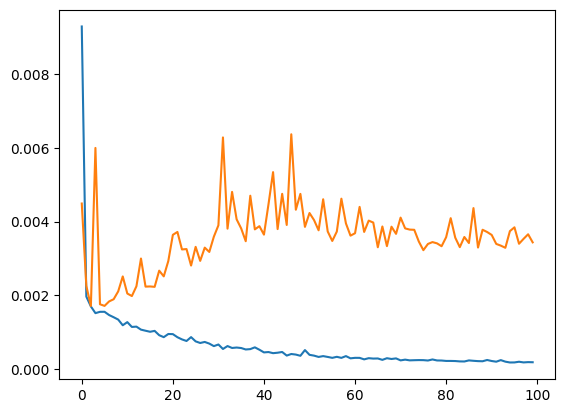

In [24]:
model_CNNvanillaGRU = Sequential()
model_CNNvanillaGRU.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNvanillaGRU.add(MaxPooling1D(pool_size=2))
model_CNNvanillaGRU.add(GRU(128, activation='tanh'))
model_CNNvanillaGRU.add(Dense(n_output))

model_CNNvanillaGRU.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNvanillaGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNvanillaGRU.history.history['loss'], model_CNNvanillaGRU.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 4s 19ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - mean_absolute_percentage_error: 18.8417 - r2_score: 0.5936 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532 - val_mean_absolute_percentage_error: 6.8895 - val_r2_score: 0.9330
Epoch 2/100
117/117 [==============================] - 2s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - mean_absolute_percentage_error: 10.6335 - r2_score: 0.9210 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460 - val_mean_absolute_percentage_error: 5.8711 - val_r2_score: 0.9499
Epoch 3/100
117/117 [==============================] - 2s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - mean_absolute_percentage_error: 9.8967 - r2_score: 0.9333 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495 - val_mean_absolute_percentage_error: 6.4514 - val_r2_score: 0.9420
Epoch 4/100
117/117 [==============================] - 2s 15ms/step - loss: 0.0017 - root_me

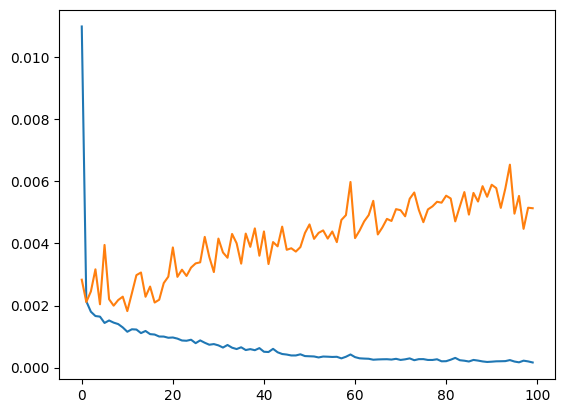

In [25]:
model_CNNstackedGRU = Sequential()
model_CNNstackedGRU.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNstackedGRU.add(MaxPooling1D(pool_size=2))
model_CNNstackedGRU.add(GRU(64, activation='tanh', return_sequences=True))
model_CNNstackedGRU.add(GRU(64, activation='tanh'))
model_CNNstackedGRU.add(Dense(n_output))

model_CNNstackedGRU.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNstackedGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNstackedGRU.history.history['loss'], model_CNNstackedGRU.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 4s 13ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - mean_absolute_percentage_error: 23.5515 - r2_score: 0.4659 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659 - val_mean_absolute_percentage_error: 8.4089 - val_r2_score: 0.8973
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - mean_absolute_percentage_error: 10.8124 - r2_score: 0.9163 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0540 - val_mean_absolute_percentage_error: 6.7661 - val_r2_score: 0.9310
Epoch 3/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - mean_absolute_percentage_error: 10.0931 - r2_score: 0.9297 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529 - val_mean_absolute_percentage_error: 6.6459 - val_r2_score: 0.9337
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0018 - root_mean

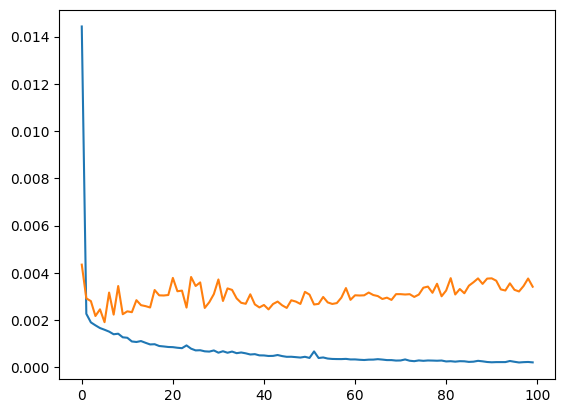

In [26]:
model_CNNbiGRU = Sequential()
model_CNNbiGRU.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNbiGRU.add(MaxPooling1D(pool_size=2))
model_CNNbiGRU.add(Bidirectional(GRU(64, activation='tanh')))
model_CNNbiGRU.add(Dense(n_output))

model_CNNbiGRU.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNbiGRU.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNbiGRU.history.history['loss'], model_CNNbiGRU.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 1s 7ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - mean_absolute_percentage_error: 20.7285 - r2_score: 0.4934 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523 - val_mean_absolute_percentage_error: 6.7958 - val_r2_score: 0.9352
Epoch 2/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0022 - root_mean_squared_error: 0.0467 - mean_absolute_percentage_error: 10.8257 - r2_score: 0.9191 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546 - val_mean_absolute_percentage_error: 6.8384 - val_r2_score: 0.9294
Epoch 3/100
117/117 [==============================] - 1s 5ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - mean_absolute_percentage_error: 10.1244 - r2_score: 0.9306 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539 - val_mean_absolute_percentage_error: 7.1601 - val_r2_score: 0.9312
Epoch 4/100
117/117 [==============================] - 1s 6ms/step - loss: 0.0018 - root_mean_

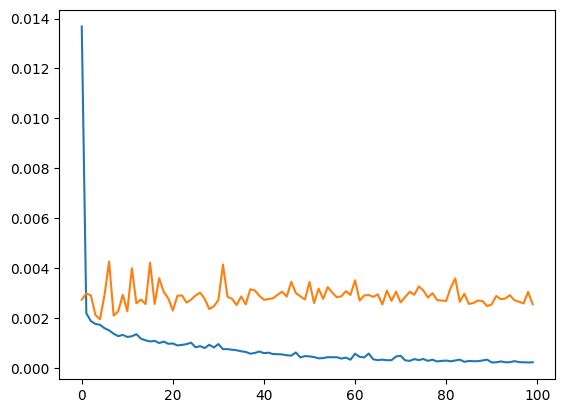

In [27]:
model_CNNvanillaRNN = Sequential()
model_CNNvanillaRNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNvanillaRNN.add(MaxPooling1D(pool_size=2))
model_CNNvanillaRNN.add(SimpleRNN(128, activation='relu'))
model_CNNvanillaRNN.add(Dense(n_output))

model_CNNvanillaRNN.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNvanillaRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNvanillaRNN.history.history['loss'], model_CNNvanillaRNN.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 2s 11ms/step - loss: 0.0261 - root_mean_squared_error: 0.1616 - mean_absolute_percentage_error: 27.9167 - r2_score: 0.0327 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593 - val_mean_absolute_percentage_error: 7.7870 - val_r2_score: 0.9168
Epoch 2/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - mean_absolute_percentage_error: 11.6575 - r2_score: 0.9108 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690 - val_mean_absolute_percentage_error: 9.0311 - val_r2_score: 0.8871
Epoch 3/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - mean_absolute_percentage_error: 10.4742 - r2_score: 0.9267 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459 - val_mean_absolute_percentage_error: 6.0817 - val_r2_score: 0.9500
Epoch 4/100
117/117 [==============================] - 1s 9ms/step - loss: 0.0017 - root_mean

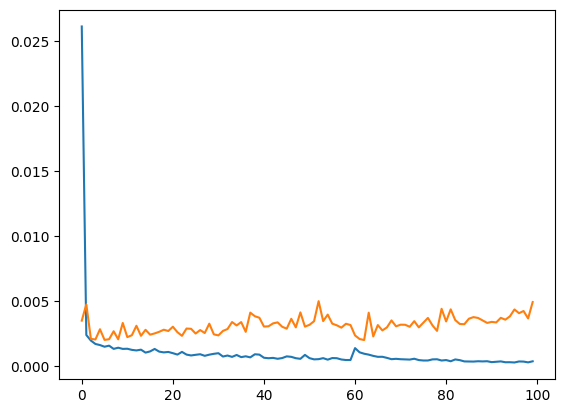

In [28]:
model_CNNstackedRNN = Sequential()
model_CNNstackedRNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNstackedRNN.add(MaxPooling1D(pool_size=2))
model_CNNstackedRNN.add(SimpleRNN(64, activation='relu', return_sequences=True))
model_CNNstackedRNN.add(SimpleRNN(64, activation='relu'))
model_CNNstackedRNN.add(Dense(n_output))

model_CNNstackedRNN.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNstackedRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNstackedRNN.history.history['loss'], model_CNNstackedRNN.history.history['val_loss'])

Epoch 1/100
117/117 [==============================] - 2s 12ms/step - loss: 0.0235 - root_mean_squared_error: 0.1533 - mean_absolute_percentage_error: 27.8337 - r2_score: 0.1295 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603 - val_mean_absolute_percentage_error: 8.1255 - val_r2_score: 0.9139
Epoch 2/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - mean_absolute_percentage_error: 12.1112 - r2_score: 0.9027 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485 - val_mean_absolute_percentage_error: 6.7553 - val_r2_score: 0.9443
Epoch 3/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - mean_absolute_percentage_error: 10.5839 - r2_score: 0.9243 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511 - val_mean_absolute_percentage_error: 7.1281 - val_r2_score: 0.9381
Epoch 4/100
117/117 [==============================] - 1s 10ms/step - loss: 0.0018 - root_m

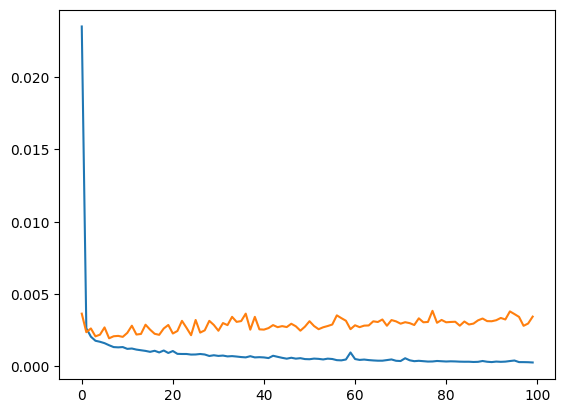

In [29]:
model_CNNbiRNN = Sequential()
model_CNNbiRNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, n_features)))
model_CNNbiRNN.add(MaxPooling1D(pool_size=2))
model_CNNbiRNN.add(Bidirectional(SimpleRNN(64, activation='relu')))
model_CNNbiRNN.add(Dense(n_output))

model_CNNbiRNN.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError(), R2Score()])
model_CNNbiRNN.fit(X_Train, Y_Train, epochs=100, batch_size=20, validation_data=(X_Valid, Y_Valid))

plt.plot(range(100), model_CNNbiRNN.history.history['loss'], model_CNNbiRNN.history.history['val_loss'])

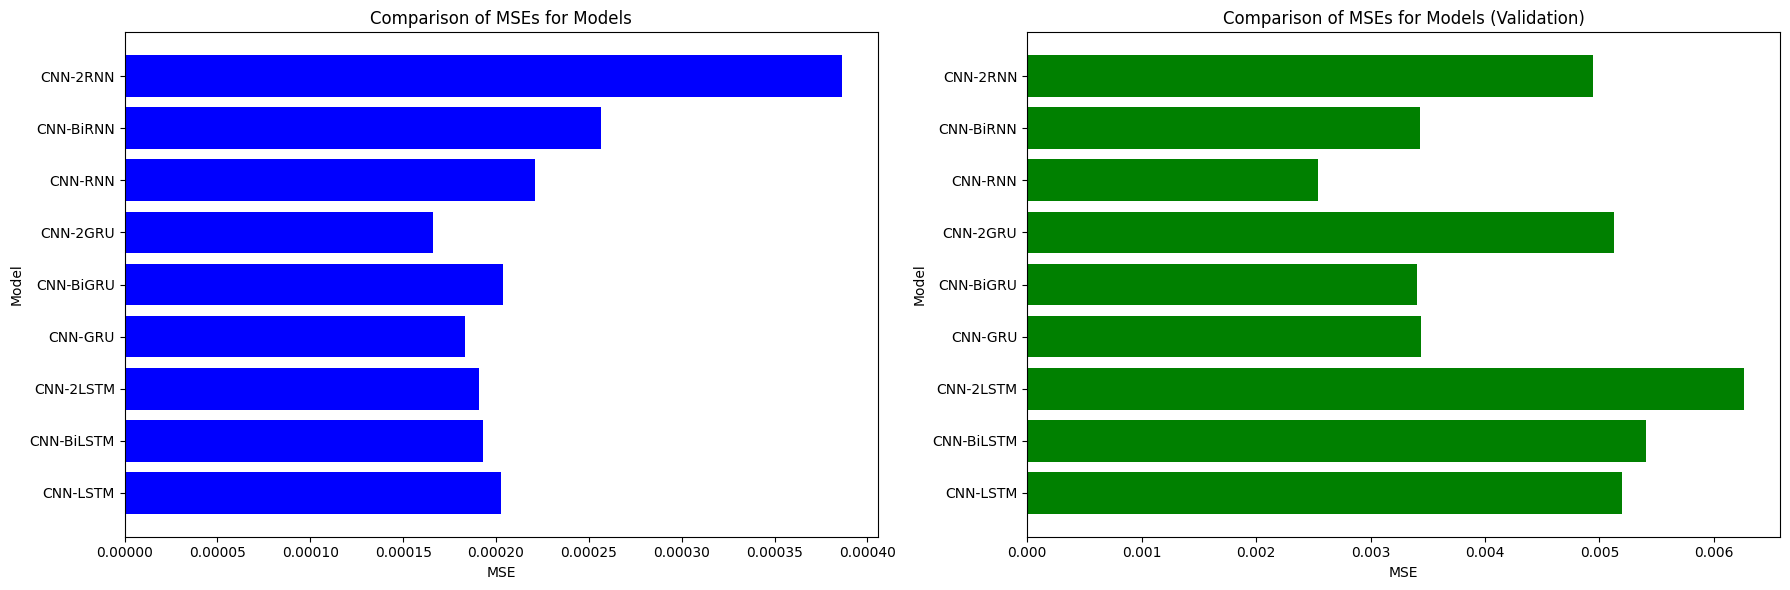

In [30]:
model_names = ['CNN-LSTM', 'CNN-BiLSTM', 'CNN-2LSTM', 'CNN-GRU', 'CNN-BiGRU', 'CNN-2GRU', 'CNN-RNN', 'CNN-BiRNN', 'CNN-2RNN']

model_mse = [model_CNNvanillaLSTM.history.history['loss'][-1], model_CNNbiLSTM.history.history['loss'][-1], model_CNNstackedLSTM.history.history['loss'][-1],
             model_CNNvanillaGRU.history.history['loss'][-1], model_CNNbiGRU.history.history['loss'][-1], model_CNNstackedGRU.history.history['loss'][-1],
             model_CNNvanillaRNN.history.history['loss'][-1], model_CNNbiRNN.history.history['loss'][-1], model_CNNstackedRNN.history.history['loss'][-1]]

model_mse_validation = [model_CNNvanillaLSTM.history.history['val_loss'][-1], model_CNNbiLSTM.history.history['val_loss'][-1], model_CNNstackedLSTM.history.history['val_loss'][-1],
                        model_CNNvanillaGRU.history.history['val_loss'][-1], model_CNNbiGRU.history.history['val_loss'][-1], model_CNNstackedGRU.history.history['val_loss'][-1],
                        model_CNNvanillaRNN.history.history['val_loss'][-1], model_CNNbiRNN.history.history['val_loss'][-1], model_CNNstackedRNN.history.history['val_loss'][-1]]


fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].barh(model_names, model_mse, color='blue')
axes[0].set_xlabel('MSE')
axes[0].set_ylabel('Model')
axes[0].set_title('Comparison of MSEs for Models')

axes[1].barh(model_names, model_mse_validation, color='green')
axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Model')
axes[1].set_title('Comparison of MSEs for Models (Validation)')

plt.tight_layout()
plt.show()

In [31]:
df_CNNwithValidation = pd.DataFrame({'model':model_names, 'MSE':model_mse, 'MSE Validation': model_mse_validation})
df_CNNwithValidation

model       MSE  MSE Validation
0    CNN-LSTM  0.000203        0.005196
1  CNN-BiLSTM  0.000193        0.005409
2   CNN-2LSTM  0.000191        0.006264
3     CNN-GRU  0.000183        0.003438
4   CNN-BiGRU  0.000204        0.003408
5    CNN-2GRU  0.000166        0.005131
6     CNN-RNN  0.000221        0.002543
7   CNN-BiRNN  0.000256        0.003431
8    CNN-2RNN  0.000386        0.004942

In [52]:
## SAVE MODELS
models = {'LSTM': model_vanillaLSTM, 'BiLSTM': model_biLSTM, '2LSTM': model_stackedLSTM, 'CNN-LSTM': model_CNNvanillaLSTM, 'CNN-BiLSTM': model_CNNbiLSTM, 'CNN-2LSTM': model_CNNstackedLSTM, 
          'GRU': model_vanillaGRU, 'BiGRU': model_biGRU, '2GRU': model_stackedGRU, 'CNN-GRU': model_CNNvanillaGRU, 'CNN-BiGRU': model_CNNbiGRU, 'CNN-2GRU': model_CNNstackedGRU,
          'RNN': model_vanillaRNN, 'BiRNN': model_biRNN, '2RNN': model_stackedRNN, 'CNN-RNN': model_CNNvanillaRNN, 'CNN-BiRNN': model_CNNbiRNN, 'CNN-2RNN': model_CNNstackedRNN,}

for model_ in models:
    models[f'{model_}'].save(f'.\models\{model_}_{n_steps}-{n_features}-{n_output}_20231220.h5')

c:\Users\a.zohdi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
## LOAD MODELS
models = {'LSTM': 0, 'BiLSTM': 0, '2LSTM': 0, 'CNN-LSTM': 0, 'CNN-BiLSTM': 0, 'CNN-2LSTM': 0, 
          'GRU': 0, 'BiGRU': 0, '2GRU': 0, 'CNN-GRU': 0, 'CNN-BiGRU': 0, 'CNN-2GRU': 0,
          'RNN': 0, 'BiRNN': 0, '2RNN': 0, 'CNN-RNN': 0, 'CNN-BiRNN': 0, 'CNN-2RNN': 0,}

for model_ in models:
    models[f'{model_}'] = load_model(f'.\models\{model_}_{n_steps}-{n_features}-{n_output}_20231220.h5')

In [15]:
model_CNNstackedGRU.predict(X_Test[0].reshape((1, 100, 31)))[0, -1]

1/1 [==============================] - 0s 489ms/step


0.7338752

In [16]:
train_metrics = model_CNNstackedGRU.evaluate(X_Test, Y_Test)

# Print the metrics
print("Train Metrics:")
for metric_name, metric_value in zip(model_CNNstackedGRU.metrics_names, train_metrics):
    print(f"{metric_name}: {metric_value}")


23/23 [==============================] - 1s 6ms/step - loss: 0.0135 - root_mean_squared_error: 0.1162 - mean_absolute_percentage_error: 11.9999 - r2_score: -1.0092
Train Metrics:
loss: 0.013508694246411324
root_mean_squared_error: 0.11622690409421921
mean_absolute_percentage_error: 11.999930381774902
r2_score: -1.00919508934021


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class Model(tf.keras.Model):
    def __init__(self, configs):
        super(Model, self).__init__()

        # Remove this, as it does not have a direct equivalent in Keras
        # self.lucky = nn.Embedding(configs.enc_in, configs.d_model // 2)

        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.enc_in = configs.enc_in
        self.patch_len = configs.patch_len
        self.d_model = configs.d_model

        self.linear_patch = layers.Dense(self.d_model)
        self.relu = layers.Activation('relu')

        self.gru = layers.GRU(
            units=self.d_model,
            return_sequences=True,
            return_state=True,
            recurrent_initializer='glorot_uniform',
            bias_initializer='zeros',
            batch_input_shape=(None, None, self.d_model)
        )

        self.pos_emb = tf.Variable(tf.random.normal((self.pred_len // self.patch_len, self.d_model // 2)))
        self.channel_emb = tf.Variable(tf.random.normal((self.enc_in, self.d_model // 2)))

        self.dropout = layers.Dropout(configs.dropout)
        self.linear_patch_re = layers.Dense(self.patch_len)

    def call(self, inputs, training=False):
        x, x_mark, y_true, y_mark = inputs
        seq_last = x[:, -1:, :]
        x = x - seq_last

        B, L, C = x.shape
        N = self.seq_len // self.patch_len
        M = self.pred_len // self.patch_len
        W = self.patch_len
        d = self.d_model

        xw = tf.transpose(x, perm=[0, 2, 1])  # B, L, C -> B, C, L
        xw = tf.reshape(xw, (B * C, N, -1))  # B, C, L -> B * C, N, W
        xd = self.linear_patch(xw)  # B * C, N, W -> B * C, N, d
        enc_in = self.relu(xd)

        _, enc_out = self.gru(enc_in, training=training)
        enc_out = tf.tile(enc_out, [1, 1, M])  # 1, B * C, d -> 1, B * C, M * d -> 1, B * C * M, d

        dec_in = tf.concat([
            tf.tile(tf.expand_dims(self.pos_emb, axis=0), [B * C, 1, 1]),  # B * C, M, d//2
            tf.tile(tf.expand_dims(self.channel_emb, axis=1), [1, M, 1])  # B * C, M, d//2
        ], axis=-1)
        dec_in = tf.reshape(dec_in, (B * C * M, 1, d))  # B * C, M, d -> B * C * M, d -> B * C * M, 1, d

        dec_out = self.gru(dec_in, initial_state=enc_out, training=training)[0]  # B * C * M, 1, d

        yd = self.dropout(dec_out, training=training)
        yw = self.linear_patch_re(yd)  # B * C * M, 1, d -> B * C * M, 1, W
        y = tf.transpose(tf.reshape(yw, (B, C, -1)), perm=[0, 2, 1])  # B, C, H

        y = y + seq_last

        return y

In [123]:
xau_test = XAU.copy()
xau_test.dropna(inplace=True)
xau_test.drop(['Date', 'High', 'Low', 'Open'], axis=1, inplace=True)
# xau_test = xau_test[['Price']]

normal_xau, maxmin_dict = maxmin_normalization(xau_test, 0.8)
X, Y = to_supervised(normal_xau, 'Price', 100, 20)

X_Train, X_Valid, X_Test = X[:int(0.8 * 0.8 * len(X)),:], X[int(0.8 * 0.8 * len(X)):int(0.8 * len(X)),:], X[int(0.8 * len(X)):,:]
Y_Train, Y_Valid, Y_Test = Y[:int(0.8 * 0.8 * len(Y)),:], Y[int(0.8 * 0.8 * len(Y)):int(0.8 * len(Y)),:], Y[int(0.8 * len(Y)):,:]

n_steps , n_features, n_output = X_Train.shape[1], X_Train.shape[2], Y_Train.shape[1]

C:\Users\a.zohdi\AppData\Local\Temp\ipykernel_22376\2619667246.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[f'{column_}'] = (train_set[f'{column_}'] - min_) / (max_ - min_)
C:\Users\a.zohdi\AppData\Local\Temp\ipykernel_22376\2619667246.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[f'{column_}'] = (test_set[f'{column_}'] - min_) / (max_ - min_)


In [62]:
N = 5

B, L, C = X_Train.shape 
print(f"Number of Samples = {B}\nSeries Length = {L}\nFeatures of data point = {C}")
print(f"\n(B, L, C) = {X_Train.shape}")

X_Train_w = np.transpose(X_Train, axes=[0, 2, 1]) # B, L, C -> B, C, L
X_Train_w = X_Train_w.reshape((B * C, N, L//N)) # B, C, L -> B * C, N, W

X_Train_w.shape

Number of Samples = 2412
Series Length = 100
Features of data point = 1

(B, L, C) = (2412, 100, 1)


(2412, 5, 20)

In [63]:
X_Train_w[-1]

array([[0.41677978, 0.41135046, 0.41666001, 0.41908724, 0.42212925,
        0.43270045, 0.41848043, 0.42644875, 0.42680804, 0.42790987,
        0.42953068, 0.42656053, 0.418193  , 0.4101129 , 0.41464797,
        0.40877952, 0.40394903, 0.40835635, 0.40241605, 0.39332194],
       [0.39402456, 0.39980518, 0.40216853, 0.40156971, 0.40170544,
        0.4003561 , 0.40723057, 0.40469955, 0.40038804, 0.38267889,
        0.38299028, 0.38296632, 0.38416397, 0.38430768, 0.38322182,
        0.385162  , 0.39404851, 0.39143765, 0.38864315, 0.38924197],
       [0.39133385, 0.38881082, 0.38467496, 0.38374878, 0.38706226,
        0.38775689, 0.38785271, 0.38915414, 0.39026396, 0.38693451,
        0.38992064, 0.39192469, 0.37405586, 0.37283426, 0.36999984,
        0.36468231, 0.36396372, 0.36562445, 0.3630056 , 0.35740862],
       [0.35184357, 0.34885745, 0.35262603, 0.34381936, 0.35257014,
        0.35577983, 0.35642655, 0.35421491, 0.35642655, 0.35474187,
        0.34397106, 0.34794724, 0.34346007, 0

In [64]:
X_Train[-1]

array([[0.41677978],
       [0.41135046],
       [0.41666001],
       [0.41908724],
       [0.42212925],
       [0.43270045],
       [0.41848043],
       [0.42644875],
       [0.42680804],
       [0.42790987],
       [0.42953068],
       [0.42656053],
       [0.418193  ],
       [0.4101129 ],
       [0.41464797],
       [0.40877952],
       [0.40394903],
       [0.40835635],
       [0.40241605],
       [0.39332194],
       [0.39402456],
       [0.39980518],
       [0.40216853],
       [0.40156971],
       [0.40170544],
       [0.4003561 ],
       [0.40723057],
       [0.40469955],
       [0.40038804],
       [0.38267889],
       [0.38299028],
       [0.38296632],
       [0.38416397],
       [0.38430768],
       [0.38322182],
       [0.385162  ],
       [0.39404851],
       [0.39143765],
       [0.38864315],
       [0.38924197],
       [0.39133385],
       [0.38881082],
       [0.38467496],
       [0.38374878],
       [0.38706226],
       [0.38775689],
       [0.38785271],
       [0.389

In [122]:
from tensorflow.keras.layers import Permute, ReLU

SegRNN_model = Sequential()
SegRNN_model.add(Permute((2, 1), input_shape=(n_steps, n_features)))
SegRNN_model.add(Reshape((C, N, -1)))
SegRNN_model.add(Dense(units=64, input_shape=(1, 5,)))
SegRNN_model.add(ReLU())
# SegRNN_model.add(GRU(units=32, return_sequences=True, return_state=True, batch_input_shape=(None, n_features, N, 32)))
# SegRNN_model.add(GRU(units=32, return_sequences=True, return_state=True))
# SegRNN_model.add(RepeatVector(4))
SegRNN_model.output_shape

(None, 1, 5, 64)

In [ ]:
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.layers import Embedding, GRU, Input, Dense, Dropout, Reshape, Concatenate

class SegRNN(KerasModel):
    def __init__(self): # def __init__(self, config)
        super(SegRNN, self).__init__()

        self.seq_len = 100
        self.pred_len = 20
        self.enc_in = 7
        self.patch_len = 5
        self.d_model = 64

        self.linear_patch = Dense(units=self.d_model, input_shape=(self.patch_len,))
        self.relu = lambda x: tf.keras.activations.relu(x)

        self.gru = GRU(units=self.d_model, return_sequences=True, return_state=True, bias_initializer='ones')

        self.pos_emb = tf.Variable(tf.random.normal(shape=(self.pred_len // self.patch_len, self.d_model // 2)))
        self.channel_emb = tf.Variable(tf.random.normal(shape=(self.enc_in, self.d_model // 2)))

        self.dropout = Dropout(rate=0.5) # rate=configs.dropout
        self.linear_patch_re = Dense(units=self.patch_len)   

    def call(self, inputs):
        x, _, _, _ = inputs

        # Remove the following line as Keras does not have an equivalent to x.detach()
        # seq_last = x[:, -1:, :].numpy()
        # x = x - seq_last

        B, L, C = x.shape
        N = self.seq_len // self.patch_len
        M = self.pred_len // self.patch_len
        W = self.patch_len
        d = self.d_model

        # Reshape input for linear patch layer
        xw = Reshape((B * C, N, W))(tf.transpose(x, perm=[0, 2, 1]))
        xd = self.linear_patch(xw)
        enc_in = self.relu(xd)

        # GRU layer
        enc_out = self.gru(enc_in)[1]
        enc_out = tf.repeat(enc_out, M, axis=1)

        # Positional and channel embeddings
        pos_emb = Reshape((1, M, d // 2))(self.pos_emb)
        channel_emb = Reshape((B, M, d // 2))(self.channel_emb)
        dec_in = Concatenate(axis=-1)([pos_emb, channel_emb])
        dec_in = Reshape((B * M, 1, d))(dec_in)

        # GRU layer for decoding
        dec_out = self.gru(dec_in, initial_state=enc_out)[0]

        # Dropout and linear patch reconstruction
        yd = self.dropout(dec_out)
        yw = self.linear_patch_re(yd)
        y = Reshape((B, C, -1))(yw)
        y = tf.transpose(y, perm=[0, 2, 1])

        # Remove the following lines as Keras handles these automatically
        # y = y + seq_last
        # return y

        return y     


In [148]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Input, Dense, Dropout, Reshape, Concatenate


seq_len = 100
pred_len = 20
enc_in = 7
patch_len = 5
d_model = 64

B, L, C = X_Train.shape
N = seq_len // patch_len
M = pred_len // patch_len
W = patch_len
d = d_model
print(B, L, C, N, M, W, d)

xw = tf.transpose(X_Train, perm=[0, 2, 1])
xw = tf.reshape(xw, [B*C, N, W])
# xw = Reshape((C, N, W))(xw) # Reshape((B * C, N, W))
# xd = Dense(units=d_model, input_shape=(patch_len,))(xw)
xw.shape

2324 100 31 20 4 5 64


TensorShape([72044, 20, 5])